# Import Library

In [1]:
## PyTorch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from utils.utils import *
from utils.surface_area import *

## Tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GRU, Input, Dropout, Bidirectional, MaxPooling1D, LSTM, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
import tensorflow as tf
import sklearn
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os

## XGBoost
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import pandas as pd
import numpy as np
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.preprocessing import StandardScaler
import pickle

import os
import sys
import re
import copy
import string
import math
import numpy as np
import pandas as pd
import category_encoders as ce

from operator import itemgetter
from itertools import groupby


# Explore Data

In [55]:
df_train = pd.read_csv('data/train/train.csv')
df_train = df_train.dropna(subset=['functional_groups'])
df_train = df_train.reset_index(drop=True)
print(df_train.isnull().sum())

MOFname                                             0
volume [A^3]                                        0
weight [u]                                          0
surface_area [m^2/g]                                0
void_fraction                                       0
void_volume [cm^3/g]                                0
functional_groups                                   0
metal_linker                                        0
organic_linker1                                     0
organic_linker2                                     0
topology                                            0
CO2/N2_selectivity                                  0
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]    2085
CO2_working_capacity [mL/g]                         0
dtype: int64


## Dataset and DataLoader

In [56]:
class MOFDataset(Dataset):
    def __init__(self, df, features, target):
        self.df = df
        self.features = features
        self.target = target
    
    def __len__(self):
        return len(self.df);
    
    def __getitem__(self, idx):
        feat = torch.tensor(self.df[self.features].values)
        target = torch.tensor(self.df[self.target].values)
        return feat, target

In [57]:
features = ['void_volume [cm^3/g]', 'void_fraction', 'surface_area [m^2/g]']
target = ['CO2_working_capacity [mL/g]']
train = MOFDataset(df_train, features, target)

bs = 64
train_dataloader = DataLoader(train, batch_size=bs, shuffle=True)
print(len(train_dataloader), len(df_train)/bs)

1068 1067.03125


## Explore Nan and Inf in Heat Absorp

In [58]:
heat_absorp = np.array(df_train['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]'])
print("Count Nan: {}".format(np.isnan(heat_absorp).sum()))
print("Count Inf: {}".format(np.isinf(heat_absorp).sum()))

Count Nan: 2085
Count Inf: 2


In [59]:
num_catalog = 2
bound_range = [0, 7] # [0, 7, 10, 20, 40]
count = []
mask = []

for i, bound in enumerate(bound_range):
    if i == len(bound_range)-1:
        m = np.logical_and(bound < df_train['CO2/N2_selectivity'], df_train['CO2/N2_selectivity'] <= np.inf)
        mask.append(m)
        count.append(m.sum())
    else:
        m = np.logical_and(bound < df_train['CO2/N2_selectivity'], df_train['CO2/N2_selectivity'] <= bound_range[i+1])
        mask.append(m)
        count.append(m.sum())

catalog = np.zeros_like(df_train['CO2/N2_selectivity'].values)
for i, m in enumerate(mask):
    catalog[m] = i

df_train.insert(11, "catalog CO2/N2", catalog)

## Explore Nan in Function groups

In [60]:
function_groups_encoder = {}

for i, ele in enumerate(df_train['functional_groups'].unique()):
    function_groups_encoder[ele] = i

# print(function_groups_encoder)
json.dump(function_groups_encoder, open("model/general/encoder/functional_groups_encoder.json", "w"))

## Explore Topology

In [61]:
topo_encoder = {}

for i, ele in enumerate(df_train['topology'].unique()):
    topo_encoder[ele] = i

print(topo_encoder)
json.dump(topo_encoder, open("model/general/encoder/topology_encoder.json", "w"))

{'pcu': 0, 'etb': 1, 'sra': 2, 'acs': 3, 'fof': 4, 'bcu': 5, 'nbo': 6, 'tbo': 7, 'pts': 8, 'the': 9, 'rht': 10}


## Insert Density Values

In [62]:
df_train.insert(loc=3, column="density [g/cm^3]", value=(df_train["weight [u]"] / df_train["volume [A^3]"]) * 1.66054)

## Fill Zero Surface Area with GSA

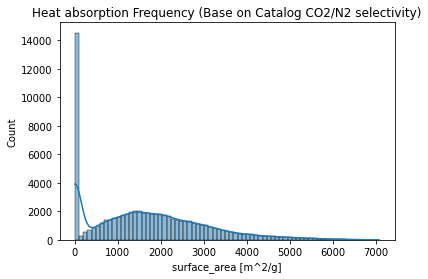

In [63]:
sns.histplot(data=df_train, x='surface_area [m^2/g]', kde=True)
plt.title('Heat absorption Frequency (Base on Catalog CO2/N2 selectivity)')
plt.show()

## Encode

### Ordinal Encoder

In [64]:
encoder = {'functional_groups': function_groups_encoder}
df_train = df_train.replace(encoder)

### Hashing Encoder

In [65]:
encoder = ce.HashingEncoder(cols='topology',n_components=10)
topo_encode = encoder.fit_transform(df_train['topology'])

df_train =df_train.drop('topology', axis=1)
df_train = pd.concat([topo_encode, df_train], axis=1)
pickle.dump(encoder, open('model/hash_encode_topology.pkl', 'wb'))

## Data Correlation

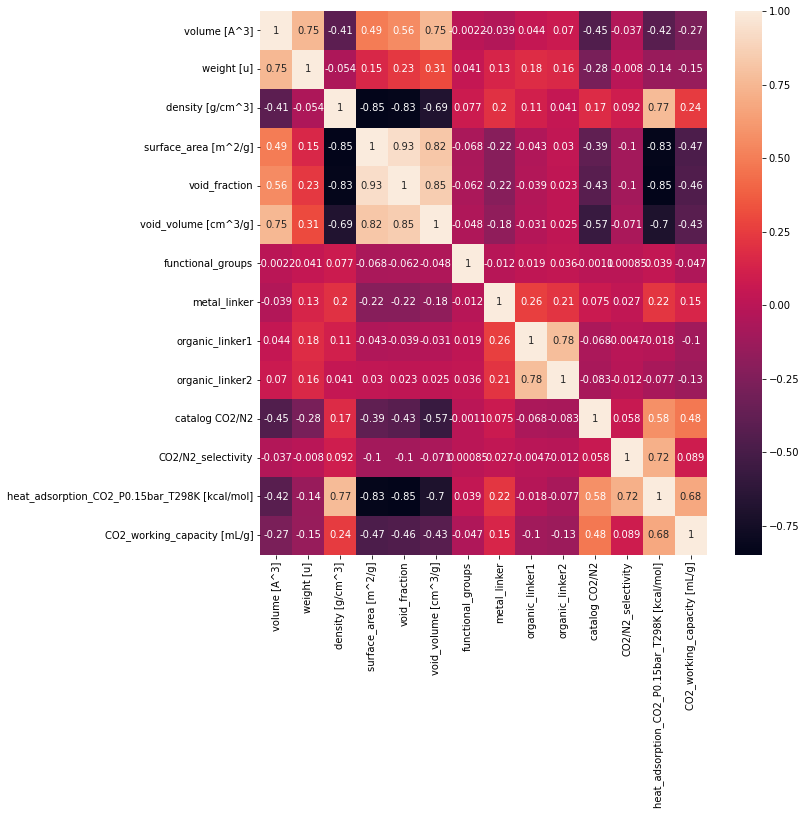

In [66]:
diagnosis_data = df_train.drop(labels=['MOFname'] + ['col_{}'.format(i) for i in range(10)], axis=1)

plt.figure(figsize=(10, 10))
sns.heatmap(data=diagnosis_data.corr(), annot=True)
plt.show()

## Preprocessing Data

### Extract Features and Target and train_test_split

In [67]:
all_features = list(df_train.columns)
all_features.remove('MOFname')
all_features.remove('functional_groups')
all_features.remove('CO2_working_capacity [mL/g]')

features_idx = {}
for idx, feat in enumerate(all_features):
    features_idx[feat] = idx

json.dump(features_idx, open('model/general/features_idx.json', 'w'))
json.dump(all_features, open('model/general/features.json', 'w'))

In [68]:
features = ['void_volume [cm^3/g]', 'void_fraction', 'surface_area [m^2/g]']
target = ['CO2_working_capacity [mL/g]']

X, y = df_train[all_features].values, df_train[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(check_nan_inf(X_train), check_nan_inf(X_test))

1465 622


### Target Encode Topology

In [69]:
# target_encoder_train_test(df_train, X_train, X_test, y_train, y_test, features_idx, 'topology')

# X_train = X_train.astype(float)
# X_test = X_test.astype(float)
# print(X_train.shape, X_test.shape)

### Fill nan and inf (Heat adsorption)

In [70]:
clean_heat_adsorption_train_test(X_train, X_test, features_idx, num_catalog)

print(check_nan_inf(X_train), check_nan_inf(X_test))

0 0


### Convert CO2/N2 selectivity by square root selectivity and multiply by heat adsorption

In [71]:
# X_train[:, features_idx['CO2/N2_selectivity']] = np.sqrt(X_train[:, features_idx['CO2/N2_selectivity']]) * X_train[:, features_idx['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']]
# X_test[:, features_idx['CO2/N2_selectivity']] = np.sqrt(X_test[:, features_idx['CO2/N2_selectivity']]) * X_test[:, features_idx['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']]

### Scale Data

In [72]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Model

## MLP

In [27]:
def create_model(dim):
    input_ = Input(shape=(dim, ))
    x = Dense(62, activation='relu')(input_)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=input_, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.004), loss='mean_absolute_error', metrics=['mean_absolute_error'])  
    return model

In [28]:
model = create_model(X_train.shape[1])

In [29]:
hist = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=0)

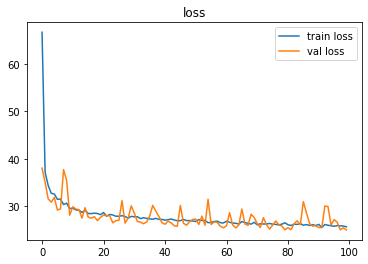

In [30]:
show_history(hist)

In [31]:
print("MAE: {}".format(hist.history['val_loss'][-1]))

MAE: 25.069549560546875


## XGBoost

In [73]:
n_estimators = 80
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=n_estimators)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_train)
mae = mean_absolute_error(y_train, preds)
print("train MAE: {}".format(mae))

preds = xg_reg.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print("val MAE: {}".format(mae))

train MAE: 16.95537703981899
val MAE: 20.523049348438178


In [24]:
matric = []
fold_no = 1
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train, test in kf.split(X, y):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    
    clean_heat_adsorption_train_test(X_train, X_test, features_idx, 2)
    
    xg_reg.fit(X_train, y_train)

    y_pred = xg_reg.predict(X_test)
    print('Fold No:', fold_no)
    print('MAE', round(mean_absolute_error(y_test, y_pred), 2))
    print()
    matric.append(mean_absolute_error(y_test, y_pred))
    fold_no += 1

print("Average MAE: {}".format(np.array(matric).mean()))

Fold No: 1
MAE 20.38

Fold No: 2
MAE 20.31

Fold No: 3
MAE 20.15

Fold No: 4
MAE 19.91

Fold No: 5
MAE 20.17

Average MAE: 20.183684701037286


###  Train all Data

In [74]:
clean_heat_adsorption(X, features_idx, 2)

sc = StandardScaler()
X = sc.fit_transform(X)
pickle.dump(sc, open('model/general/standardscaler.pkl', 'wb'))

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=n_estimators)
xg_reg.fit(X,y)
xg_reg.save_model('model/model.json')

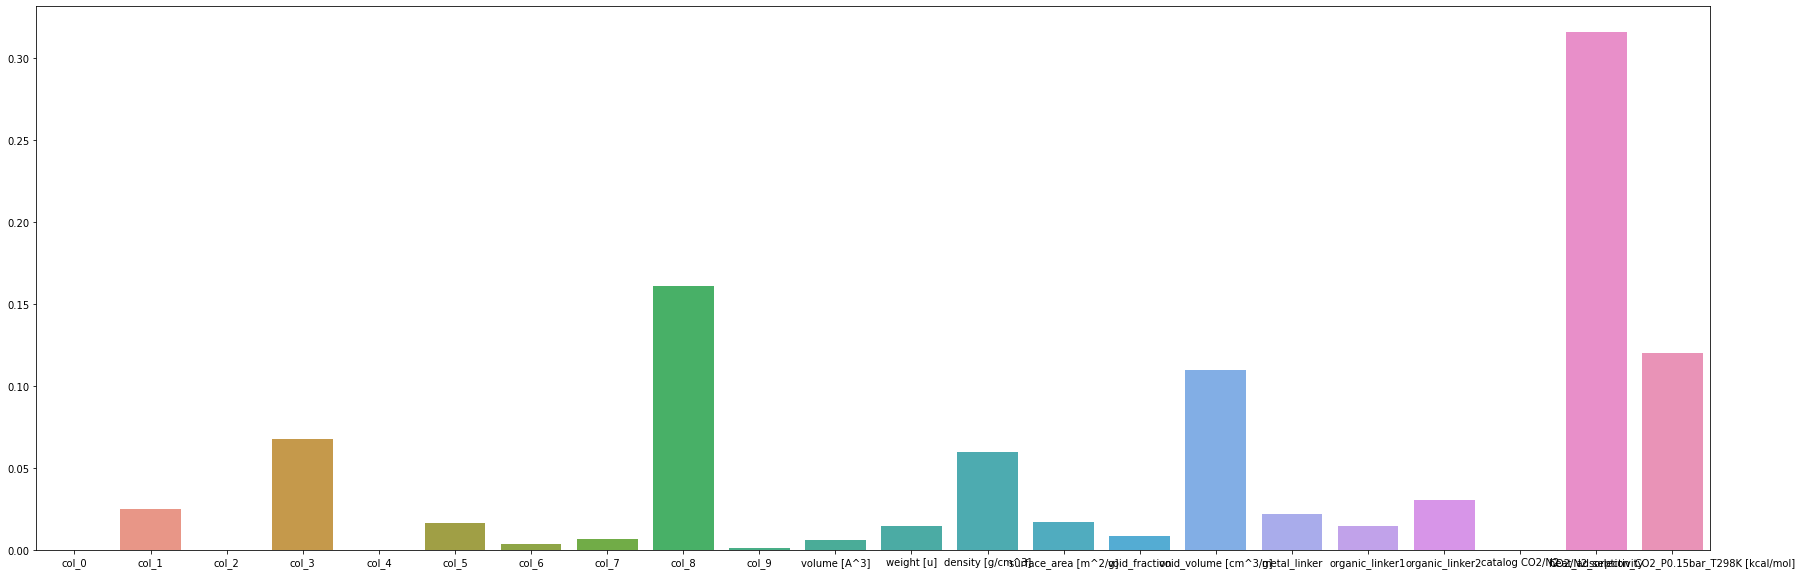

In [75]:
plt.figure(figsize=(30, 10))
sns.barplot(x=all_features, y=xg_reg.feature_importances_)
plt.show()